##### Copyright 2020 The TensorFlow Quantum Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

[link text](https://)# Binary classification of quantum states

Initial Tutorial Author : Antonio J. Martinez

Initial Tutorial Contributors : Masoud Mohseni

Initial Tutorial Created : 2020-Feb-14

Initial Tutorial Last updated : 2020-Feb-29

---

Current Experiment Author : Anneliese Brei

Current Experiment Created : 2022-Jan-3

Current Experiment Last updated : 2022-Jan-3

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/binary_classifier/binary_classifier.ipynb)

An elementary learning task is [binary classification](https://en.wikipedia.org/wiki/Binary_classification), a supervised task in which the learner is to distinguish which of two classes a given datapoint has been drawn from.  Here, using ideas from the paper [Universal discriminative quantum neural networks](https://arxiv.org/abs/1805.08654) in the one-qubit setting, we train a hybrid quantum-classical neural network to distinguish between quantum data sources.

## Import dependencies

In [ ]:
!pip install --upgrade tensorflow
!pip install qutip

In [ ]:
!pip install tensorflow-quantum

In [ ]:
import cirq
import numpy as np
import qutip
import random
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Quantum dataset
For our quantum dataset, you will generate two blobs on the surface of the Bloch sphere.  The task will be to learn a model to distinguish members of these blobs.  To do this, you first select two axes in the X-Z plane of the block sphere, then select random points uniformly distributed around them:

In [ ]:
def generate_dataset(qubit, theta_a, theta_b, num_samples):
  """Generate a dataset of points on `qubit` near the two given angles; labels
  for the two clusters use a one-hot encoding.
  """
  q_data = []
  bloch = {"a": [[], [], []], "b": [[], [], []]}
  labels = []
  blob_size = abs(theta_a - theta_b) / 5
  for _ in range(num_samples):
    coin = random.random()
    spread_x = np.random.uniform(-blob_size, blob_size)
    spread_y = np.random.uniform(-blob_size, blob_size)
    if coin < 0.5:
      label = [1, 0]
      angle = theta_a + spread_y
      source = "a"
    else:
      label = [0, 1]
      angle = theta_b + spread_y
      source = "b"
    labels.append(label)
    q_data.append(cirq.Circuit(cirq.ry(-angle)(qubit), cirq.rx(-spread_x)(qubit)))
    bloch[source][0].append(np.cos(angle))
    bloch[source][1].append(np.sin(angle)*np.sin(spread_x))
    bloch[source][2].append(np.sin(angle)*np.cos(spread_x))
  return tfq.convert_to_tensor(q_data), np.array(labels), bloch

In [ ]:
def build_model(theta_a, theta_b):

  qubit = cirq.GridQubit(0, 0)

  # Build the quantum model layer 1
  theta = sympy.Symbol('theta')
  q_model = cirq.Circuit(cirq.ry(theta)(qubit))
  q_data_input = tf.keras.Input(
      shape=(), dtype=tf.dtypes.string)
  expectation = tfq.layers.PQC(q_model, cirq.Z(qubit))
  expectation_output = expectation(q_data_input)

  # Attach the classical SoftMax classifier
  classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
  classifier_output = classifier(expectation_output)
  model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)

  # Standard compilation for classification
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])
  
  return model, qubit

In [ ]:
# Constants
theta_a = 1
theta_b = 4
num_samples = 500 # Number of datapoints for training and for testing
iterations = 10
num_epochs = 15

Test effect of increasing the number of samples for
1. Training
2. Testing

In [ ]:
def run_trial():

  history_p = []

  # Train with 250 datapoints
  qubit = cirq.GridQubit(0, 0)
  q_data, labels, _ = generate_dataset(qubit, theta_a, theta_b, 250)
  model_250, _ = build_model(theta_a, theta_b)
  history = model_250.fit(x=q_data, y=labels, epochs=1, verbose=0)
  history_p.append(history.history['loss'][-1])

  # Train with 500 datapoints
  qubit = cirq.GridQubit(0, 0)
  q_data, labels, _ = generate_dataset(qubit, theta_a, theta_b, 500)
  model_500, _ = build_model(theta_a, theta_b)
  history = model_500.fit(x=q_data, y=labels, epochs=1, verbose=0)
  history_p.append(history.history['loss'][-1])

  # Train with 1000 datapoints
  qubit = cirq.GridQubit(0, 0)
  q_data, labels, _ = generate_dataset(qubit, theta_a, theta_b, 1000)
  model_1000, _ = build_model(theta_a, theta_b)
  history = model_1000.fit(x=q_data, y=labels, epochs=1, verbose=0)
  history_p.append(history.history['loss'][-1])

  # Train with 2500 datapoints
  qubit = cirq.GridQubit(0, 0)
  q_data, labels, _ = generate_dataset(qubit, theta_a, theta_b, 2500)
  model_2500, _ = build_model(theta_a, theta_b)
  history = model_2500.fit(x=q_data, y=labels, epochs=1, verbose=0)
  history_p.append(history.history['loss'][-1])

  # Train with 5000 datapoints
  qubit = cirq.GridQubit(0, 0)
  q_data, labels, _ = generate_dataset(qubit, theta_a, theta_b, 5000)
  model_5000, _ = build_model(theta_a, theta_b)
  history = model_5000.fit(x=q_data, y=labels, epochs=1, verbose=0)
  history_p.append(history.history['loss'][-1])

  return history_p


In [ ]:
trial1 = run_trial()
trial2 = run_trial()
trial3 = run_trial()
trial4 = run_trial()
trial5 = run_trial()
trial6 = run_trial()
trial7 = run_trial()
trial8 = run_trial()
trial9 = run_trial()
trial10 = run_trial()

print(trial1)
print(trial2)
print(trial3)
print(trial4)
print(trial5)
print(trial6)
print(trial7)
print(trial8)
print(trial9)
print(trial10)

[0.796583354473114, 0.4899729788303375, 0.4236915409564972, 0.12572377920150757, 0.03116297349333763]
[0.1533435434103012, 0.6629505157470703, 0.18709762394428253, 0.21895138919353485, 0.028639599680900574]
[0.34772586822509766, 0.7511314749717712, 0.16615690290927887, 0.13512764871120453, 0.009793916717171669]
[0.3063710033893585, 0.7329695820808411, 0.28117936849594116, 0.11302819848060608, 0.06851477921009064]
[0.23130153119564056, 0.4853506088256836, 0.06090562418103218, 0.05753123760223389, 0.05764543637633324]
[0.43178248405456543, 0.17919570207595825, 0.7823801636695862, 0.08810203522443771, 0.14738912880420685]
[0.4172082841396332, 0.7359139919281006, 0.18952737748622894, 0.18537798523902893, 0.03801374137401581]
[1.015500545501709, 0.6107043027877808, 0.7447136640548706, 0.05645031854510307, 0.03916721045970917]
[0.6897916197776794, 0.31915196776390076, 0.1412244290113449, 0.13427157700061798, 0.034638505429029465]
[0.7566666603088379, 0.18187019228935242, 0.4282267391681671, 

In [ ]:
average = []
for i in range(len(trial1)):
  average.append((trial1[i] + trial2[i] + trial3[i] + trial4[i] + trial5[i]
                  + trial6[i] + trial7[i] + trial8[i] + trial9[i] + trial10[i]) / 10)

print(average)

[0.5146274894475937, 0.5149211317300797, 0.34051034338772296, 0.12285582236945629, 0.04832163751125336]


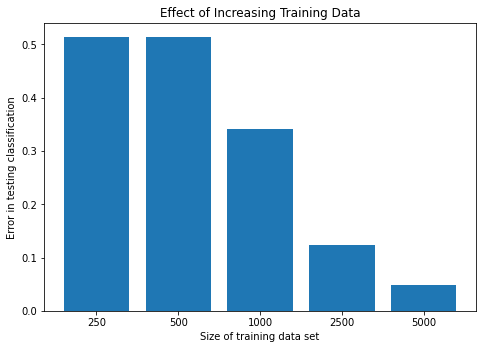

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['250', '500', '1000', '2500', '5000']
ax.bar(labels,average)
plt.title("Effect of Increasing Training Data")
plt.xlabel("Size of training data set")
plt.ylabel("Error in testing classification")
plt.show()

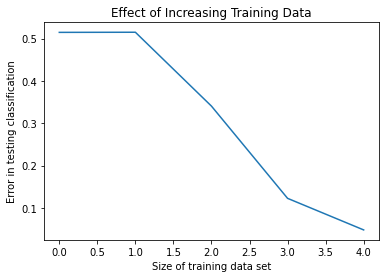

In [ ]:
plt.plot(average, label="training data points")
plt.title("Effect of Increasing Training Data")
plt.xlabel("Size of training data set")
plt.ylabel("Error in testing classification")
plt.show()